In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import fitsio
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from qso_sample import QSOSample
import dipole
import multipoles

### conversion $C_1 \leftrightarrow \mathcal{D}$

In [3]:
def C_1(dipole_amplitude):  # from Gibelyou & Huterer (2012)
    return 4 * np.pi / 9 * dipole_amplitude**2

def D(C_1):
    return np.sqrt(C_1) * 9 / (4 * np.pi)

### convergence

In [4]:
# convergence: dipole measured on the full sky
ntrials = 10000

#### Quaia

In [5]:
res = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_fullsky_ellmax1_{ntrials}trials.npy',
                        allow_pickle=True).item()
Cells1 = res['Cells_fullsky']
ntrialss = res['ntrials']
mu = res['mu']
print(res['comment'])

# check additional max ells
max_ells = [2,3]
Cells_higher = []
for i, max_ell_ in enumerate(max_ells):
    res = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_fullsky_ellmax{max_ell_}_{ntrials}trials.npy',
                        allow_pickle=True).item()
    Cells_higher.append(res['Cells_fullsky'])
    assert np.all(res['ntrials'] == ntrialss)
    assert res['mu'] == mu

Quaia G<20.0, masking completeness < 0.5; correcting by completeness to estimate mean source density mu, but NOT weighting by completeness in lstsq


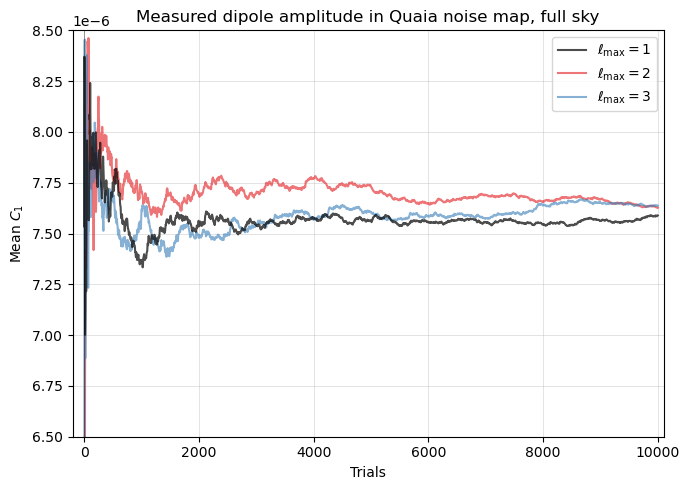

In [6]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(ntrialss, Cells1[:,0], 'k-', alpha=0.7, label=r'$\ell_\mathrm{max}=1$', zorder=10)
colors = list(map(mpl.cm.Set1, range(len(max_ells))))
for i, max_ell_ in enumerate(max_ells):
    ax.plot(ntrialss, Cells_higher[i][:,0], ls='-', c=colors[i], alpha=0.6, label=r'$\ell_\mathrm{max}=$'f'{max_ell_}')
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(0, c='k', alpha=0.5, lw=0.5)
ax.set_xlim(-200, 10100)
ax.set_ylim(6.5e-6, 8.5e-6)
ax.set_xlabel('Trials')
ax.set_ylabel(r'Mean $C_1$')
ax.set_title('Measured dipole amplitude in Quaia noise map, full sky')
ax.legend()

In [7]:
start = 2000
C1_fullsky_quaia = np.mean(Cells1[:,0][ntrialss > start])
print(C1_fullsky_quaia)
for Cells_ in Cells_higher:
    print(np.mean(Cells_[:,0][ntrialss > start]))

7.560653960529763e-06
7.692500108012535e-06
7.5964099347525935e-06


#### CatWISE AGNs

In [8]:
res = np.load(f'/scratch/aew492/quasars/noise_Cells/catwise_agns/noise_Cells_fullsky_ellmax1_{ntrials}trials.npy',
                        allow_pickle=True).item()
Cells1 = res['Cells_fullsky']
ntrialss = res['ntrials']
mu = res['mu']
print(res['comment'])

# check additional max ells
max_ells = [2,3]
Cells_higher = []
for i, max_ell_ in enumerate(max_ells):
    res = np.load(f'/scratch/aew492/quasars/noise_Cells/catwise_agns/noise_Cells_fullsky_ellmax{max_ell_}_{ntrials}trials.npy',
                        allow_pickle=True).item()
    Cells_higher.append(res['Cells_fullsky'])
    assert np.all(res['ntrials'] == ntrialss)
    assert res['mu'] == mu

CatWISE AGNs, masking completeness < 0.5; correcting by completeness to estimate mean source density mu, but NOT weighting by completeness in lstsq


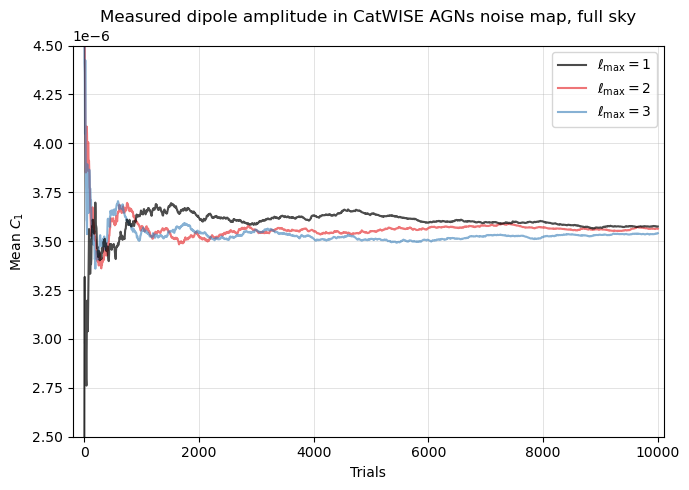

In [9]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(ntrialss, Cells1[:,0], 'k-', alpha=0.7, label=r'$\ell_\mathrm{max}=1$', zorder=10)
colors = list(map(mpl.cm.Set1, range(len(max_ells))))
for i, max_ell_ in enumerate(max_ells):
    ax.plot(ntrialss, Cells_higher[i][:,0], ls='-', c=colors[i], alpha=0.6, label=r'$\ell_\mathrm{max}=$'f'{max_ell_}')
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(0, c='k', alpha=0.5, lw=0.5)
ax.set_xlim(-200, 10100)
ax.set_ylim(2.5e-6, 4.5e-6)
ax.set_xlabel('Trials')
ax.set_ylabel(r'Mean $C_1$')
ax.set_title('Measured dipole amplitude in CatWISE AGNs noise map, full sky')
ax.legend()

In [10]:
start = 2000
C1_fullsky_catwise = np.mean(Cells1[:,0][ntrialss > start])
print(C1_fullsky_catwise)
for Cells_ in Cells_higher:
    print(np.mean(Cells_[:,0][ntrialss > start]))

3.6047530454249946e-06
3.558693543048595e-06
3.5232599508410313e-06


### shot noise on full sky up to $\ell_\mathrm{max}$

In [11]:
# shot noise on full sky, up to some max ell, average of n trials
max_ell = 8
ntrials = 2000

# Quaia
res = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_fullsky_ellmax{max_ell}_{ntrials}trials.npy',
                        allow_pickle=True).item()
ells = res['ells']
Cells_trials_quaia = res['Cells_fullsky']
ntrialss = res['ntrials']

# CatWISE
res = np.load(f'/scratch/aew492/quasars/noise_Cells/catwise_agns/noise_Cells_fullsky_ellmax{max_ell}_{ntrials}trials.npy',
                        allow_pickle=True).item()
assert np.all(res['ells'] == ells)
assert np.all(res['ntrials'] == ntrialss)
Cells_trials_catwise = res['Cells_fullsky']

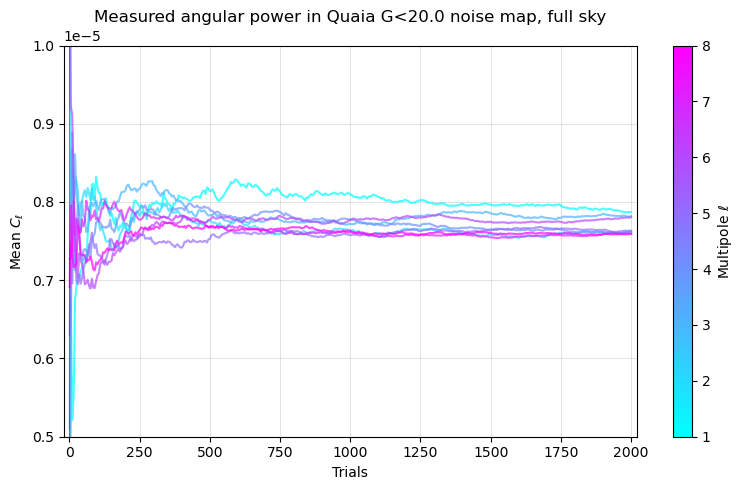

In [12]:
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
# colors = list(map(mpl.cm.cool, range(max_ell)))
norm = mpl.colors.Normalize(vmin=1, vmax=max_ell)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')
for i, ell in enumerate(range(1, max_ell+1)):
    ax.plot(ntrialss, Cells_trials_quaia[:,i], c=smap.to_rgba(ell), ls='-', alpha=0.7)
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(0, c='k', alpha=0.5, lw=0.5)
ax.set_xlim(-20, 2020)
ax.set_ylim(5e-6, 1e-5)
ax.set_xlabel('Trials')
ax.set_ylabel(r'Mean $C_\ell$')
ax.set_title('Measured angular power in Quaia G<20.0 noise map, full sky')
fig.colorbar(smap, ax=ax, label=r'Multipole $\ell$')

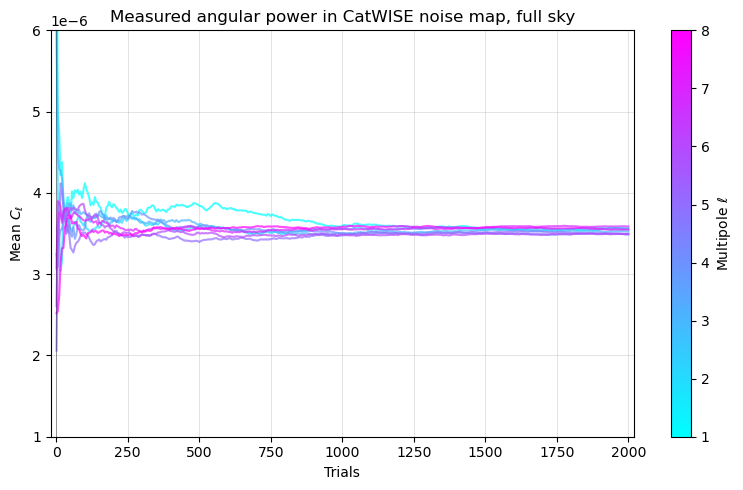

In [13]:
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
# colors = list(map(mpl.cm.cool, range(max_ell)))
norm = mpl.colors.Normalize(vmin=1, vmax=max_ell)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')
for i, ell in enumerate(ells):
    ax.plot(ntrialss, Cells_trials_catwise[:,i], c=smap.to_rgba(ell), ls='-', alpha=0.7)
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(0, c='k', alpha=0.5, lw=0.5)
ax.set_xlim(-20, 2020)
ax.set_ylim(1e-6, 6e-6)
ax.set_xlabel('Trials')
ax.set_ylabel(r'Mean $C_\ell$')
ax.set_title('Measured angular power in CatWISE noise map, full sky')
fig.colorbar(smap, ax=ax, label=r'Multipole $\ell$')

Text(0.5, 1.0, 'Shot noise estimates on the full sky (mean of 2000 trials)')

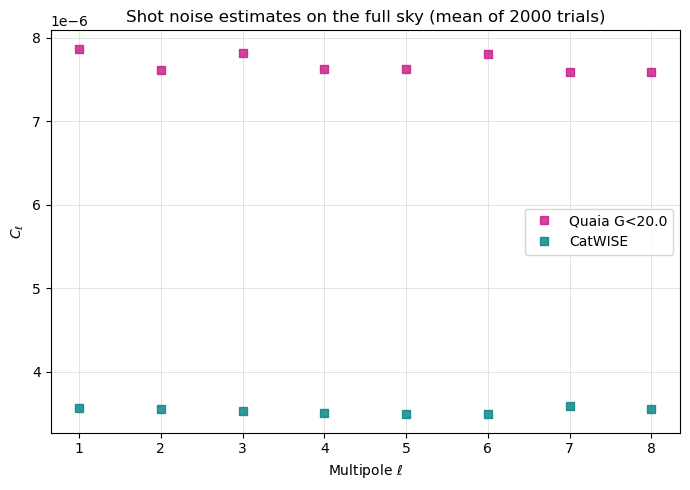

In [14]:
# compare both, mean of all trials
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(ells, Cells_trials_quaia[-1,:], marker='s', ls='None', c='mediumvioletred', alpha=0.8, label='Quaia G<20.0')
ax.plot(ells, Cells_trials_catwise[-1,:], marker='s', ls='None', c='teal', alpha=0.8, label='CatWISE')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
ax.legend()
ax.set_title(f'Shot noise estimates on the full sky (mean of {ntrials} trials)')

### shot noise cut sky with $\Lambda$ regularization

In [15]:
# Quaia
max_ells = np.arange(1, 9).astype(int)
ntrials = 500
cutsky_res = []
cutsky_res_fine = []
Lambdas_closest = np.empty(len(max_ells))
stds_closest = np.empty_like(Lambdas_closest)
for i, max_ell in enumerate(max_ells):
    res_cut = np.load(f'/scratch/aew492/quasars/noise_Cells/quaia/noise_Cells_cutsky_ellmax{max_ell}_{ntrials}trials_Lambda.npy',
                      allow_pickle=True).item()
    Lambdas, Cells_cut, stds = list(zip(*res_cut['Cells_cutsky']))
    idx_sorted = np.array(Lambdas).argsort()
    Lambdas, C1s_cut = np.array(Lambdas)[idx_sorted], np.array(Cells_cut)[idx_sorted][:,0] # to get C_1 only
    stds = np.array(stds)[idx_sorted][:,0] # standard deviation of the trials
    cutsky_res.append(np.array([Lambdas, C1s_cut, stds]))
    # interpolate on a finer grid
    Lambdas_fine = np.logspace(np.log10(min(Lambdas)), np.log10(max(Lambdas)), 101)
    C1s_cut_fine = np.interp(Lambdas_fine, Lambdas, C1s_cut)
    cutsky_res_fine.append(np.array([Lambdas_fine, C1s_cut_fine]))
    # find closest Wmask in the interpolated list to the C_1 on the full sky
    idx_closest = np.abs(C1s_cut_fine - C1_fullsky_quaia).argmin()
    Lambdas_closest[i] = Lambdas_fine[idx_closest]

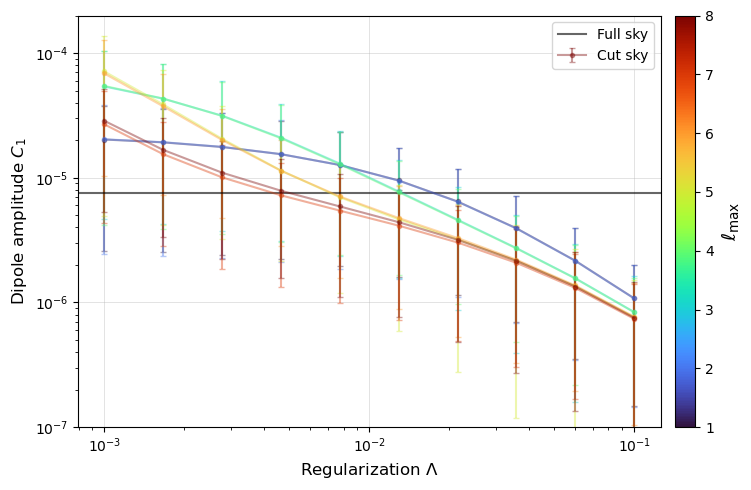

In [16]:
# plot
norm = mpl.colors.Normalize(vmin=min(max_ells), vmax=max(max_ells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
for i, max_ell in enumerate(max_ells):
    Lambdas, C1s_cut, stds = cutsky_res[i]
    label = 'Cut sky' if i==max(max_ells)-1 else ''
    ax.errorbar(Lambdas, C1s_cut, yerr=stds, capsize=2, marker='.', c=smap.to_rgba(max_ell), alpha=0.4, label=label)
    # ax.axhline(C1s_fullsky[i], c=smap.to_rgba(max_ell), alpha=0.6)
ax.axhline(C1_fullsky_quaia, c='k', alpha=0.6, label='Full sky')
ax.grid(alpha=0.5, lw=0.5)
ax.loglog()
ax.set_ylim(1e-7, 2e-4)
ax.set_xlabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_ylabel(r'Dipole amplitude $C_1$', fontsize=12)
cbar = fig.colorbar(smap, ax=ax, ticks=max_ells.astype(int), pad=.02)
cbar.set_label(label=r'$\ell_\mathrm{max}$', fontsize=14)
ax.legend()

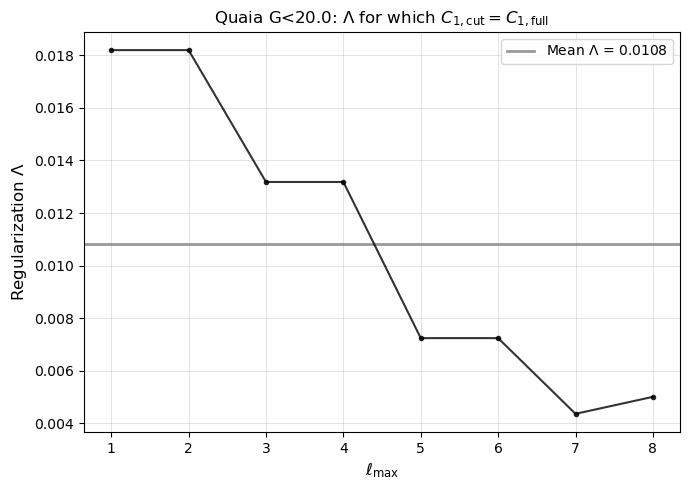

In [17]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(max_ells, Lambdas_closest, c='k', alpha=0.8, marker='.', zorder=10)
ax.axhline(np.mean(Lambdas_closest), c='grey', alpha=0.8, lw=2, label=r'Mean $\Lambda$ = 'f'{np.mean(Lambdas_closest):.4f}')
ax.grid(alpha=0.5, lw=0.5)
# ax.loglog()
ax.set_xlabel(r'$\ell_\mathrm{max}$', fontsize=12)
ax.set_ylabel(r'Regularization $\Lambda$', fontsize=12)
ax.set_title(r'Quaia G<20.0: $\Lambda$ for which $C_{1,\mathrm{cut}} = C_{1,\mathrm{full}}$')
ax.legend()

In [18]:
# save as dictionary
res = dict(zip(max_ells, Lambdas_closest))
save_fn = f'/scratch/aew492/quasars/regularization/Lambdas_quaia_noise-matched.npy'
np.save(save_fn, res)